# <center> Feature Exploration For EEG Consciousness Detection</center>


**Developed by:** Kevin Machado Gamboa


This notebook contains different signal transformation methodologies to generate features from raw EEG signals that can become inputs for our Consciousness model.

### Libraries Needed

In [1]:
# Others
import os
os.chdir('../')
import numpy as np
import random as rd
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
# Figures Size Setup
plt.rcParams['figure.figsize'] = (15,5)

# Personal Libraries
import utils
import config
import databases as dbs
import functions_main as fm

# eeg processing library
from scipy.signal import hilbert
import antropy as ant
import mne
mne.set_log_level('ERROR')  # To avoid flooding the cell outputs with messages

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## 1. Introduction

In this project, the feature extraction will always take place at the end of the data pipeline, in a phase called **Data Transformation**. This obviously required to have applied some initial-data-processing and having cutting a long EEG waveform into epochs, among other things.

We can start this excersice by loading some EEG data from our sleep and the anaesthesia dataset's. These loaded EEG data will be passed throught the **data pipeline** shown in figure 1. This contains four main blocks:

1. **Data Preparation**: Where we can do initial steps such as load the EEG files, reject bad channels or select the ones to be processed. The operations in this block are mainly implemented using the `mne` library.
2. **Data Preprocessing**: Where the main operation is the filtering of the signal. At the end of this process, we will always end up with **Epochs** of a specific time length, ready to be transformed. These operations are done also with `mne`.
3. **Data Transformation**: The first transformation of the signal is thenormalization.
4. **Ready for Model**:


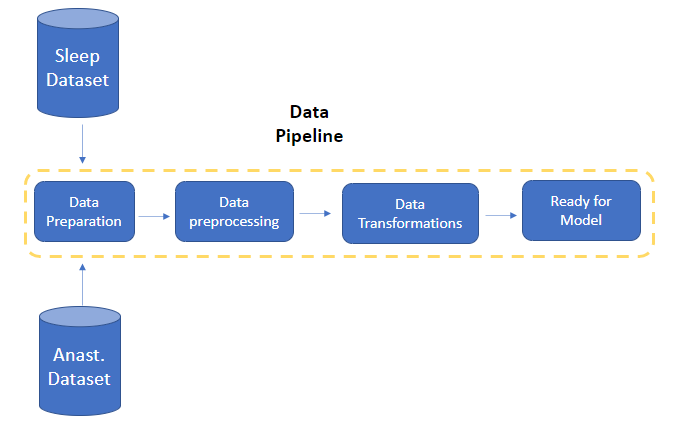

With the use the fucntion `load_epochs_labels` from our library `databases`, we automatically perform steps one and two of our **data pipeline** are implemented.


**Loading sleep dataset**

In [2]:
# initialize sleep database
sleep = dbs.sleep()
# loads [x_epochs, y_labels]
sleep.load_epochs_labels(t_files=5)
# converts labels to [0=>conscious,5* 1=>unconscious]
sleep.get_binary_labels()
# data information
print(sleep.info)

100%|██████████| 5/5 [00:12<00:00,  2.52s/it]

sleep dataset with binary labels: [0=>conscious, 1=>unconscious]
{'n_samples': {'train': 30208, 'test': 7552}, 'eeg_time': {'total': '1d-7h:28m:0s', 'train': '1d-1h:10m:24s', 'test': '0d-6h:17m:36s'}, 'class_balance': {'train': {'value': {1: 23986, 0: 6222}, 'percentage': {1: 0.7940280720338984, 0: 0.2059719279661017}}, 'test': {'value': {1: 5934, 0: 1618}, 'percentage': {1: 0.7857521186440678, 0: 0.2142478813559322}}}}


Before transforming the data, each EEG epoch in our datasets need to be normalize between -1 and 1. We can perform this step using the `dataset.transform(mpf.nor_dataset)` method.

**Normalizing Sleep dataset between -1 and 1**

In [4]:
sleep.transform(fm.nor_dataset)

  1%|▏         | 437/30208 [00:00<00:06, 4369.75it/s]

transforming training dataset


 11%|█         | 830/7552 [00:00<00:01, 3909.63it/s]

transforming test dataset


100%|██████████| 7552/7552 [00:01<00:00, 4111.98it/s]


Up to this point, we can start appliying any signal transformation to the epochs in our datasets.

For the next steps, we will select 2 epochs, each from one dataset in order to show how these **transformation algorithms** work in detail.

In [5]:
# defining the nth epoch
n1, n2 = rd.randint(0, 100), rd.randint(0, 100)
# selecting one channel
ch = 1
# selecting epoch from sleep
se = sleep.data['train']['epochs'][n1][ch]
ae = sleep.data['train']['epochs'][n2][ch]

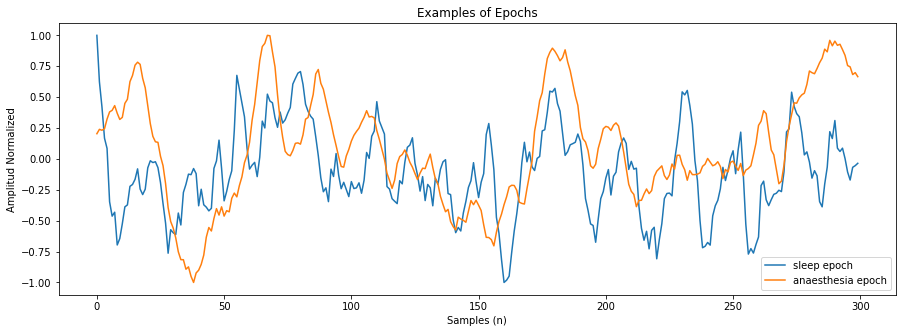

In [6]:
plt.plot(se, label='sleep epoch')
plt.plot(ae, label='anaesthesia epoch')

plt.title('Examples of Epochs')
plt.xlabel('Samples (n)')
plt.ylabel('Amplitud Normalized')
plt.legend()
plt.show()

# 2. Exploring Features Extraction (over epochs)


## 2.1 Signal Spectrogram


## 2.2 The Binarization of Hilbert Transform (Binary Matrix)

The **Binary Matrix algorithm** implemented is based on **[ref 1] (pag. 6)** and it is part of the computation of the **Lempel-Ziv complexity (LZc)** algorithm. In general terms, the algorithm showed here involves: 1. finding the absolute value of the hilbert transform of the input signal, and 2. converting the resulted signal into a binary form.

**Note: for this example a single epoch from the Anaesthesia dataset was used**

1. **Hilbert Transform Absolute:** The first step is to apply the hilbert transform of the signal (epoch) and then extract the absolut value the result

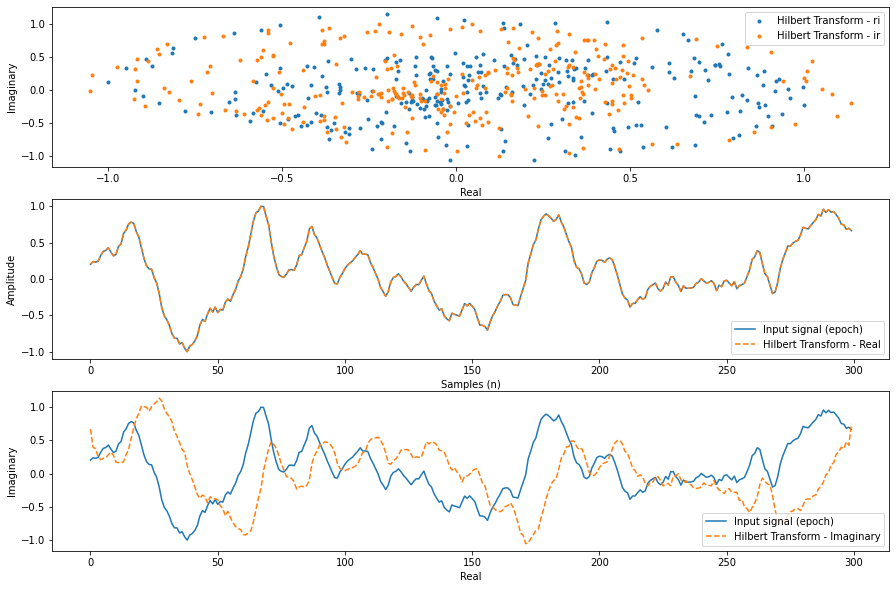

In [7]:
plt.figure(figsize=(15,10))
a = hilbert(ae)

plt.subplot(3,1,1)
plt.plot(a.real, a.imag, '.', label = 'Hilbert Transform - ri')
plt.plot(a.imag, a.real, '.', label = 'Hilbert Transform - ir' )
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.legend()

plt.subplot(3,1,2)
plt.plot(ae, label = 'Input signal (epoch)')
plt.plot(a.real, '--', label = 'Hilbert Transform - Real')
plt.xlabel('Samples (n)')
plt.ylabel('Amplitude')
plt.legend()

plt.subplot(3,1,3)
plt.plot(ae, label = 'Input signal (epoch)')
plt.plot(a.imag, '--', label = 'Hilbert Transform - Imaginary')
plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.legend()
plt.show()

The **real dimension** of the Hilbert transform contains the same wave-shape of the input signal but in values ranging from [-1,1]. In the other hand, the **imaginary dimension**, it seems that the signal has been desfasada or moved to the right side of the input signal.

In the next animation we can apreciate how the real and imaginary dimension of the Hilbert transform varies in time:

2. **Binarization:** Then, the second part is to binarize the 'real' part of the Hilbert transform, using the mean of the resulted signal as threshold:

In [8]:
# selects the real part
a = a.real
# applies threshold
b = 1*(a>np.mean(a))
print(b)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 0 0 0 0 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 1 1 1 1 1 1 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1]


In [9]:
del a, b

Given that this binarization of the Hilbert transform would be applied to each of the channels, we will ended up with a matrix nxm, where n is the number of EEG channels and m the number of samples. 

We can implement a function that performs the binary matrix to a single signal and also to all channels available as follow:

In [10]:
def binary_matrix(signal):
    # applying hilbert transform
    ht = hilbert(signal)
    # extracting real part
    e = ht.real
    # converting to binary
    b = 1*(e>np.mean(e))
    
    return b

def binary_matrix_dataset(dataset):
    
    for n, epoch in enumerate(tqdm(dataset)):
        # finds the binary matrix
        k = np.array([binary_matrix(channel) for channel in epoch])
        # Added to the dataset
        dataset[n] = np.array(k)
        
    return dataset
    
#anaesthesia.data['train']['epochs']

In [11]:
print('Shape before transformation:', sleep.data['train']['epochs'].shape)
b = binary_matrix_dataset(sleep.data['train']['epochs'])
print('Shape After transformation:', sleep.data['train']['epochs'].shape)

  2%|▏         | 672/30208 [00:00<00:04, 6719.69it/s]

Shape before transformation: (30208, 2, 300)


100%|██████████| 30208/30208 [00:04<00:00, 6777.11it/s]

Shape After transformation: (30208, 2, 300)


Data Visualization

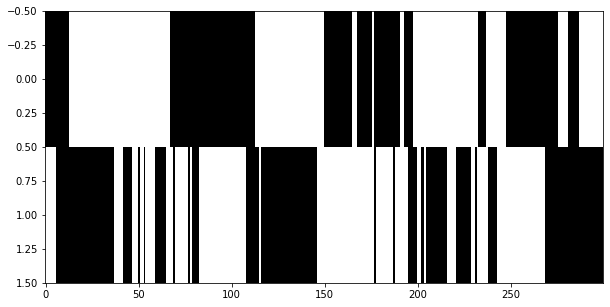

In [12]:
# generates random number
re = rd.randint(0, sleep.info['n_samples']['train'])
plt.figure(figsize=(10,5))
barprops = dict(aspect='auto', cmap='binary', interpolation='nearest')
plt.imshow(sleep.data['train']['epochs'][re], **barprops)
plt.show()

#### Binary Matrix with 66 Channels - Anaesthesia Dataset

The algorithm is also applicable to the anaesthesia dataset with any number of channels. For example, we can load the dataset with 61 channels (`config.channels_r`) and visualize how the binary matrix look in one epoch

In [13]:
sleep = dbs.sleep()
# loads [x_epochs, y_labels]
sleep.load_epochs_labels(t_files=5, n_test=0.30)
# converts labels to [0=>conscious,5* 1=>unconscious]
sleep.get_binary_labels()
# Normalize the dataset between [-1,1]
sleep.transform(fm.nor_dataset)
# applying dataset transformation
sleep.transform(fm.binary_matrix_dataset, name='hilbert_binary_matrix')

  3%|▎         | 876/26432 [00:00<00:05, 4354.06it/s]

sleep dataset with binary labels: [0=>conscious, 1=>unconscious]
transforming training dataset


  8%|▊         | 906/11328 [00:00<00:02, 4425.47it/s]

transforming test dataset


  3%|▎         | 708/26432 [00:00<00:03, 7079.53it/s]

transforming training dataset


  6%|▋         | 715/11328 [00:00<00:01, 7149.65it/s]

transforming test dataset


100%|██████████| 11328/11328 [00:01<00:00, 7070.59it/s]


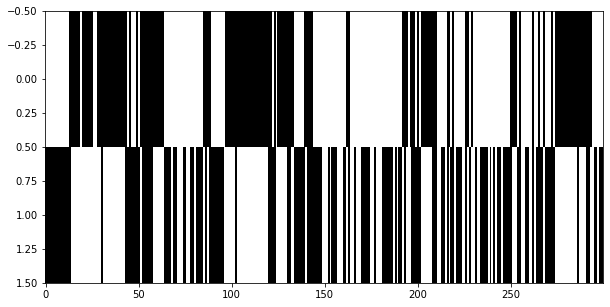

In [14]:
# generates random number
re = rd.randint(0, sleep.info['n_samples']['train'])
plt.figure(figsize=(10,5))
barprops = dict(aspect='auto', cmap='binary', interpolation='nearest')
plt.imshow(sleep.data['train']['epochs'][re], **barprops)
plt.show()

Next, we can visualize 5 different samples for conscious and unconscious 

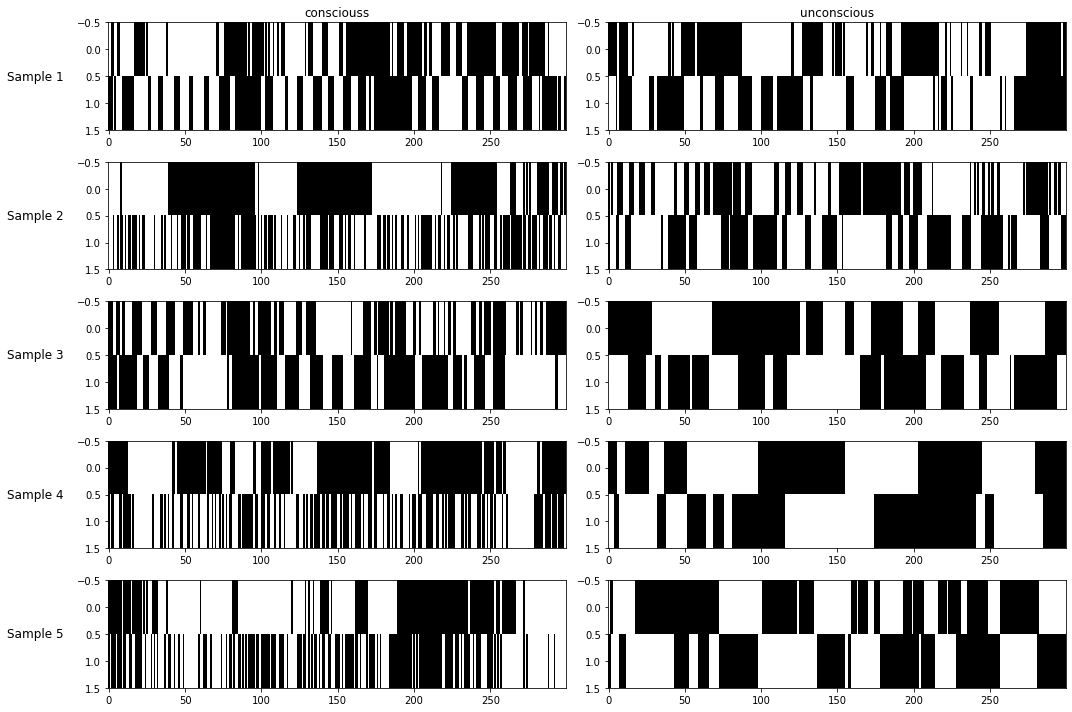

In [24]:
utils.imshow_samples(sleep.data['train'], {0: 'consciouss', 1: 'unconscious'}, bar=True)

## Frequency Band Hilbert Binary Matrix

We split this technique in three steps, starting from a signal epoch, followed by the application of a filter bank and then the binary hilbert matrix. This steps are illustrated in the image below:

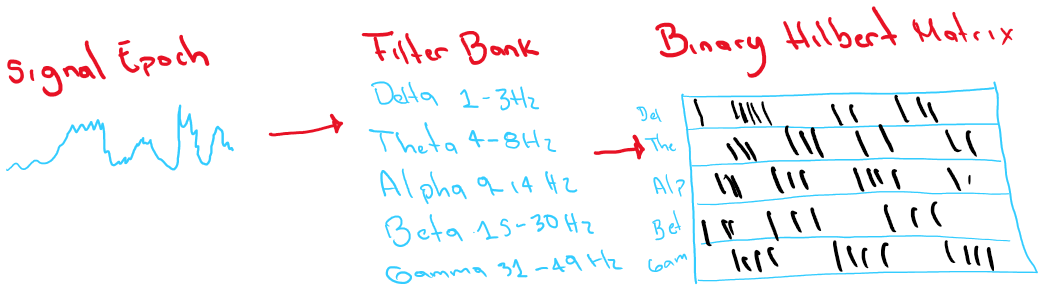

For this excersice the epoch vector `se` was used. Also the `eeg_bands` and `band_pass` filter was defined as follow:

In [27]:
# EEG bands
eeg_bands = {'Delta': (1, 4),
             'Theta': (4, 8),
             'Alpha': (8, 12),
             'Beta': (12, 30),
             'Gamma': (30, 49)}

def band_pass_bl(in_signal: np.ndarray,
                 sf: int,
                 band: tuple,
                 ) -> np.ndarray:
    """
    Applies filtering process to an input signal
    @param in_signal:
    @param sf:
    @param lowcut:
    @param highcut:
    @return:
    """
    low, high = band
    # Applies low-pass filter
    out_signal = fm.butter_lowpass_filter(in_signal, high, sf)
    # Applies high-pass filter
    out_signal = fm.butter_highpass_filter(out_signal, low, sf)

    return out_signal

Now we can apply the filter bank to the signal

In [28]:
eeg = []
for band in eeg_bands:
    eeg.append(band_pass_bl(se, 100, eeg_bands[band]))

In the image below we can visualize the signals in each band:

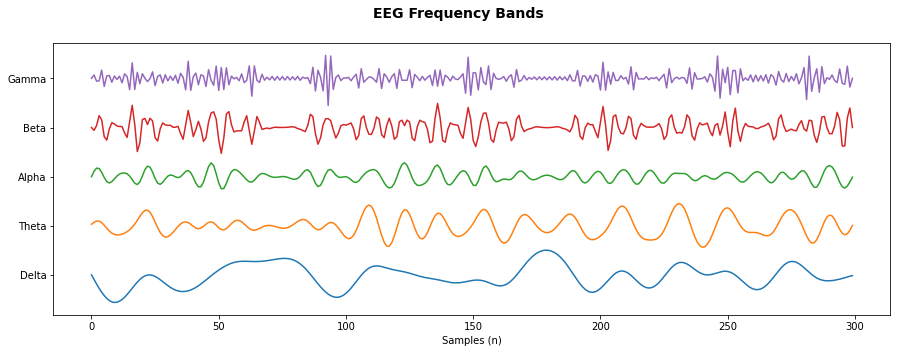

In [29]:
fig = plt.figure()
fig.suptitle('EEG Frequency Bands', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)

# loop for plotting signal
for n, signal in enumerate(eeg):
    ax.plot(n+signal)

# set xlabel
ax.set_xlabel('Samples (n)')
# set ticks
ax.set_yticks(np.arange(5))
# add labels to ticks
ax.set_yticklabels(eeg_bands.keys())
# show figure
plt.show()

Then, for each of this resulted signals, the Hilbert binarized matrix is applied

In [30]:
bm = []
for sig_band in eeg:
    bm.append(binary_matrix(sig_band))

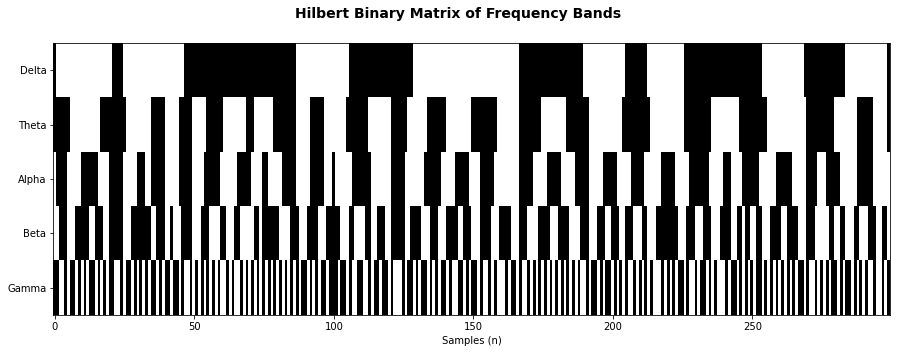

In [31]:
fig = plt.figure()
fig.suptitle('Hilbert Binary Matrix of Frequency Bands', fontsize=14, fontweight='bold')
ax = fig.add_subplot(111)
barprops = dict(aspect='auto', cmap='binary', interpolation='nearest')

# loop for plotting signal
ax.imshow(bm, **barprops)

# set xlabel
ax.set_xlabel('Samples (n)')
# set ticks
ax.set_yticks(np.arange(5))
# add labels to ticks
ax.set_yticklabels(eeg_bands.keys())
# show figure
plt.show()

We can define a function to achieve this results as follow:

In [32]:
def band_binary_matrix(signal, sf=100):
    # applying filter bank and binary matrix
    band_eeg = [binary_matrix(band_pass_bl(signal, sf, eeg_bands[band])) for band in eeg_bands]
       
    return np.array(band_eeg)
    
def band_binary_matrix_dataset(dataset):
    # initializing transformed dataset
    t_dataset = []
    for n, epoch in enumerate(tqdm(dataset)):
        # finds the binary matrix
        k = [band_binary_matrix(channel, sf=100) for channel in epoch]
        # Added to the dataset
        t_dataset.append(k)
        
    return np.array(t_dataset)

Finally, we can transform our dataset as follow:

**Note: This might take a couple of minutes**

In [ ]:
print('Shape before transformation:', sleep.data['test']['epochs'].shape)
sleep.data['test']['epochs'] = band_binary_matrix_dataset(sleep.data['test']['epochs'])
print('Shape After transformation:', sleep.data['test']['epochs'].shape)

  0%|          | 25/11328 [00:00<01:34, 120.08it/s]

Shape before transformation: (11328, 2, 300)


 33%|███▎      | 3737/11328 [00:30<01:04, 117.19it/s]

In [ ]:
# classes
classes = {0: 'Conscious', 1: 'Unconscious'}
# plots figure
utils.imshow_samples(sleep.data['test'], classes, bar=True)

In [ ]:
## 2. Spectal Connectivity



The computation implemented is based on the function `mne.connectivity.spectral_conneectivity`.


**For this example a single epoch from the sleep dataset was used.

In [ ]:
mne.viz.plot_sensors_connectivity(con[:,:,0])

In [ ]:
con[:,:,0]

## 2.2 Lempel-Ziv (LZ) complexity

The reference for the implemented Lempel-Ziv complexity of the EEG signal is available in **ref[1]**. In summary, the algorithm involves: finding the absolute of the hilbert transform of the signal, then converting the resulted signal to a binary form. This is, giving 1 if any element is greater than the mean and 0 elsewhere.

Ref: 
1. Schartner, Michael et al. “Complexity of Multi-Dimensional Spontaneous EEG Decreases during Propofol Induced General Anaesthesia.” PloS one vol. 10,8 e0133532. 7 Aug. 2015, doi:10.1371/journal.pone.0133532 - [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4529106/)

2. Hilbert transform - [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html)

The algorithm implemented step by step is stated below. We will perform this example with a single epoch. 


The first step is to apply the hilbert transform of the signal (epoch) and then extract the absolut value the result

The full algorithm is available below:

In [ ]:
def lz_algorithm(signal):
    # applying hilbert transform
    ht = hilbert(signal)
    # extracting real part
    e = ht.real
    # converting to binary
    b = 1*(e>np.mean(e))
    # LZ complexity
    lz = ant.lziv_complexity(b, normalize = True)
    
    return lz

def lz_dataset(dataset):
    """
     Applies Lempel-Ziv (LZ) complexity algorithm to the entire dataset
     """
    k = []
    for n, epoch in enumerate(tqdm(dataset)):
        # Gets normalization per channel
        k.append(np.array([lz_algorithm(channel) for channel in epoch]))
    # Added to the dataset
    dataset = np.array(k)

    return dataset

In [ ]:
sleep.data['train']['epochs'][:,0]

In [ ]:
plt.scatter(sleep.data['train']['labels'], sleep.data['train']['epochs'][:,1], label='primero')

plt.scatter(sleep.data['train']['labels'], sleep.data['train']['epochs'][:,1], label='segundo')

plt.xlabel('Real')
plt.ylabel('Imaginary')
plt.legend()
plt.show()

In [ ]:
plt.plot(se, label='sleep epoch')
plt.plot(ae, label='anaesthesia epoch')

plt.xlabel('Samples (n)')
plt.ylabel('Normalized Amplitud')
plt.legend()
plt.show()

In [ ]:
plt.plot(se, label='sleep epoch')
plt.plot(ae, label='anaesthesia epoch')

plt.xlabel('Samples (n)')
plt.ylabel('Normalized Amplitud')
plt.legend()
plt.show()

In [ ]:
plt.plot(mpf.vec_nor(zero_mean(se)), label='sleep epoch')
plt.plot(mpf.vec_nor(zero_mean(ae)), label='anaesthesia epoch')

plt.xlabel('Samples (n)')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

In [ ]:
plt.plot(zero_mean(mpf.vec_nor(se)), label='sleep epoch')
plt.plot(zero_mean(mpf.vec_nor(ae)), label='anaesthesia epoch')

plt.xlabel('Samples (n)')
plt.ylabel('Amplitud')
plt.legend()
plt.show()

## References

1. Schartner, Michael et al. “Complexity of Multi-Dimensional Spontaneous EEG Decreases during Propofol Induced General Anaesthesia.” PloS one vol. 10,8 e0133532. 7 Aug. 2015, doi:10.1371/journal.pone.0133532 - [link](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4529106/)

2. Hilbert transform - [link](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.hilbert.html)